In [1]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import concurrent.futures
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:

# Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(gpu_devices)
print("Num GPUs Available:", num_gpus)

# Print GPU details
if num_gpus > 0:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled.")

# Set TensorFlow to run on GPU
if num_gpus > 0:
    try:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print("Error setting GPU memory growth:", e)

# Re-check GPU availability after configuration
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# List available devices
print(device_lib.list_local_devices())

Num GPUs Available: 0
No GPU found. Make sure GPU is enabled.
Num GPUs Available: 0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 346170489619714026
xla_global_id: -1
]


In [33]:
non_shoplifters = r"E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\non shop lifters"
shoplifters = r"E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\shop lifters"

In [35]:
def get_unique_videos(folder_path, underscore_count):
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    print(f"\nTotal videos in '{folder_path}' before filtering: {len(video_files)}")

    # Filter out videos where the filename contains the specified number of underscores
    unique_videos = [os.path.join(folder_path, f) for f in video_files if f.count('_') != underscore_count]

    print(f"Total videos in '{folder_path}' after filtering: {len(unique_videos)}")

    return unique_videos

In [37]:
non_shop_lifters_videos = get_unique_videos(non_shoplifters, 4)  
shop_lifters_videos = get_unique_videos(shoplifters, 3) 


Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\non shop lifters' before filtering: 313
Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\non shop lifters' after filtering: 313

Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\shop lifters' before filtering: 324
Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\shop lifters' after filtering: 324


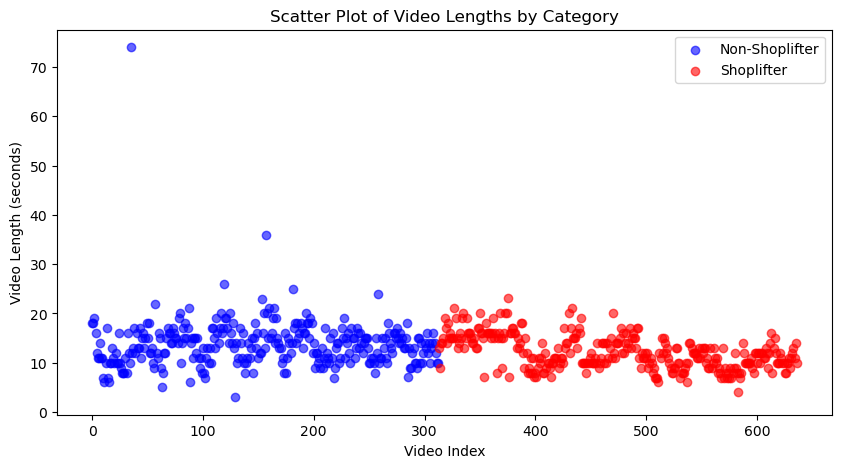

In [39]:
# Function to get video length
def get_video_length(video_path):
    """Get the duration (length) of a video in seconds."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames
    cap.release()
    
    if fps > 0:
        return frame_count / fps  # Duration in seconds
    else:
        return None  # Handle potential errors

# Extract video lengths for both categories
non_shop_lengths = [get_video_length(video) for video in non_shop_lifters_videos if get_video_length(video) is not None]
shop_lengths = [get_video_length(video) for video in shop_lifters_videos if get_video_length(video) is not None]

# Create video indices
non_shop_indices = list(range(len(non_shop_lengths)))
shop_indices = list(range(len(non_shop_lengths), len(non_shop_lengths) + len(shop_lengths)))

# Create scatter plot
plt.figure(figsize=(10, 5))

plt.scatter(non_shop_indices, non_shop_lengths, color="blue", label="Non-Shoplifter", alpha=0.6)
plt.scatter(shop_indices, shop_lengths, color="red", label="Shoplifter", alpha=0.6)

# Labels and title
plt.xlabel("Video Index")
plt.ylabel("Video Length (seconds)")
plt.title("Scatter Plot of Video Lengths by Category")
plt.legend() 
plt.show()

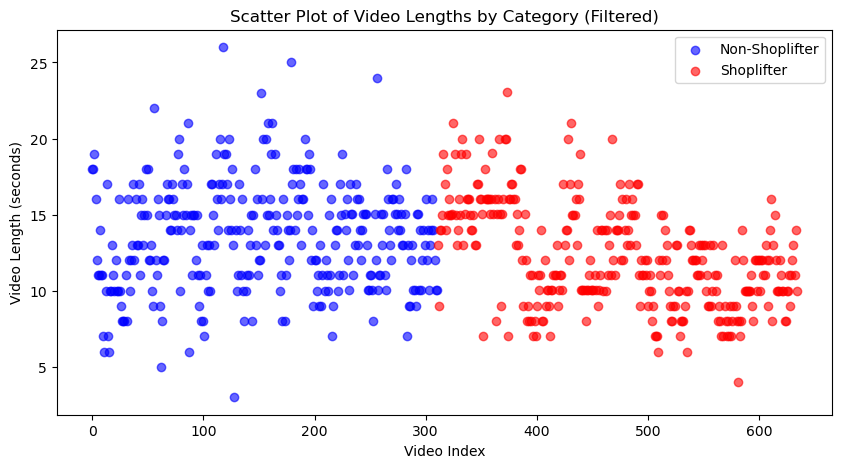

In [41]:
# Define a threshold for video length
MAX_VIDEO_LENGTH = 35  

# Filter non-shoplifter videos
filtered_non_shop_lengths = [length for length in non_shop_lengths if length <= MAX_VIDEO_LENGTH]

# Filter shoplifter videos
filtered_shop_lengths = [length for length in shop_lengths if length <= MAX_VIDEO_LENGTH]

# Create new video indices after filtering
filtered_non_shop_indices = list(range(len(filtered_non_shop_lengths)))
filtered_shop_indices = list(range(len(filtered_non_shop_lengths), len(filtered_non_shop_lengths) + len(filtered_shop_lengths)))

# Create scatter plot
plt.figure(figsize=(10, 5))

plt.scatter(filtered_non_shop_indices, filtered_non_shop_lengths, color="blue", label="Non-Shoplifter", alpha=0.6)
plt.scatter(filtered_shop_indices, filtered_shop_lengths, color="red", label="Shoplifter", alpha=0.6)

# Labels and title
plt.xlabel("Video Index")
plt.ylabel("Video Length (seconds)")
plt.title("Scatter Plot of Video Lengths by Category (Filtered)")
plt.legend()
plt.show()

In [43]:
dataset_path = r"E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet"

# Define paths for categories
categories = {
    "non shop lifters": 0,  # Label 0
    "shop lifters": 1       # Label 1
}

# Collect video paths and labels
video_paths = []
labels = []

for category, label in categories.items():
    folder_path = os.path.join(dataset_path, category)
    unique_videos = get_unique_videos(folder_path, underscore_count=4 if label == 0 else 3)  
    video_paths.extend(unique_videos)
    labels.extend([label] * len(unique_videos))  # Assign label to each video
    
label_counts = Counter(labels)
min_class_count = min(label_counts.values())
stratify = labels if min_class_count >= 2 else None

train_paths, val_paths, train_labels, val_labels = train_test_split(
    video_paths, labels, test_size=0.3,random_state=42, stratify=stratify
)


Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\non shop lifters' before filtering: 313
Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\non shop lifters' after filtering: 313

Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\shop lifters' before filtering: 324
Total videos in 'E:\Cellula Tasks\Task 5\Shop DataSet\Shop DataSet\shop lifters' after filtering: 324


In [45]:
def extract_frames(video_path, num_frames=16, target_size=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        return None  # Skip empty videos

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
        frames.append(frame)

    cap.release()

    # Repeat last frame instead of black padding
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((*target_size, 3)))

    return np.array(frames, dtype=np.float32)


def video_generator(paths, labels):
    for path, label in zip(paths, labels):
        video = extract_frames(path)
        yield video, label

In [47]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: video_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: video_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

num_train_samples = len(train_paths)
num_val_samples = len(val_paths)
print(f"Training samples: {num_train_samples}, Validation samples: {num_val_samples}")

Training samples: 445, Validation samples: 192


In [49]:
BATCH_SIZE = 4     
BUFFER_SIZE = 100 

steps_per_epoch = max(1, num_train_samples // BATCH_SIZE)
validation_steps = max(1, num_val_samples // BATCH_SIZE)

# Apply batching, shuffling, and prefetching
train_dataset = (train_dataset
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE).repeat())

val_dataset = (val_dataset
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE).repeat())

In [51]:
input_shape = (16, 128, 128, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),
    
    # First Conv Block
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    # Second Conv Block
    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Dropout(0.3),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    # Third Conv Block
    layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Dropout(0.4),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    # Forth Conv Block
    layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Dropout(0.4),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    # Global Average Pooling for better generalization
    layers.GlobalAveragePooling3D(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') 
])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_7 (Conv3D)                    │ (None, 16, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 128, 128, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 16, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_8 (Conv3D)                    │ (None, 16, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 64, 64, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 16, 64, 64, 64)      │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 64, 64, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 8, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 8, 32, 32, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 32, 32, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 8, 32, 32, 128)      │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 32, 32, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 4, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_12 (Conv3D)                   │ (None, 4, 16, 16, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 4, 16, 16, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 4, 16, 16, 256)      │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 16, 16, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 2, 8, 8, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │              

 Total params: 3,621,185 (13.81 MB)

 Trainable params: 3,620,225 (13.81 MB)

 Non-trainable params: 960 (3.75 KB)

In [53]:
checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, early_stopping]

In [55]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4436 - loss: 0.9338
Epoch 1: val_loss improved from inf to 0.69356, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.4440 - loss: 0.9335 - val_accuracy: 0.4896 - val_loss: 0.6936
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5701 - loss: 0.7624
Epoch 2: val_loss did not improve from 0.69356
111/111 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.5702 - loss: 0.7620 - val_accuracy: 0.5104 - val_loss: 0.6936
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5936 - loss: 0.7478
Epoch 3: val_loss did not improve from 0.69356
111/111 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.5936 - loss: 0.7474 - val_accuracy: 0.4896 - val_loss: 0.6941
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6286 - loss: 0.6331
Epoch 4: val_loss improved from 0.69356 to 0.68394, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - ac